In [1]:
import numpy as np
import numpy.linalg as npl
import scipy as sp
import scipy.sparse.linalg as spspl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time as gettime

# Fonctions utiles pour afficher

In [2]:
def plot3D(x,t,U,ax_label,title):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X', fontsize = 16)
    ax.set_ylabel('temps', fontsize = 16)
    ax.set_zlabel(ax_label, fontsize = 16)
    ax.view_init(elev=15, azim = 20)
    [SX,ST]=np.meshgrid(x,t)
    a = ax.plot_surface(SX,ST,U.T,cstride=1,linewidth=0,cmap='jet')
    plt.title(title,fontsize=15)
    plt.colorbar(a)
    plt.show()
def U_x_ax(x,U_sol,s):
    plt.plot(x,U_sol)
    plt.title("Solution on x axis "+s)
    plt.show()
def U_t_ax(t,U_sol,s):
    plt.plot(t,U_sol)
    plt.title("Solution on t axis "+s)
    plt.show()

In [3]:
def sol_Burger_from_Heat(h,H_sol,mu):
    """
    computes Burger solution from Heat solution via Cole-Hopf transform
    (Burger(t,x) = -2 mu d_x{Heat(t,x)}/Heat(t,x))
    using finite difference method to approximate d_x Heat(t,x)
    (needs h = Delta x and mu = diffusion)
    """
    if len(H_sol.shape) == 1:
        return -2*mu*(H_sol[2:]-H_sol[:-2])/H_sol[1:-1]/h/2
    else:
        return -2*mu*(H_sol[2:,:]-H_sol[:-2,:])/H_sol[1:-1,:]/h/2
def init_Heat_Gauss(x,param):
    """
    valeur initiale pour la chaleur : soit f(x) = Burger(t=0,x):
    return e^{-1/(2 mu) * int_0^x{Burger(0,y) dy}}
    pour une gaussienne: Burger(t=0,x) = e^{-(x-m)^2/sigma^2}
    d'où return = e^{-1/(2 mu) *(Erf((x-m)/sigma)+Erf(m/sigma))*sigma*sqrt(pi)/2}
    """
    mu = param[0]
    m = param[1]
    sigma = param[2]
    return np.exp(-np.sqrt(np.pi)/4/mu*(sp.special.erf((x-m)/sigma)+sp.special.erf(m/sigma))*sigma)
def init_Burger_Gauss(x,param):
    """
    valeur initiale pour Burger (courbe de gauss parametrisée)
    """
    mu = param[0]
    m = param[1]
    sigma = param[2]
    return np.exp(-(x-m)**2/sigma**2)
def Burger_D_Boundary_0(t,param):
    """
    valeur de dirichlet du bord x=0 pour Burger (implique Neumann non-homogène pour la chaleur en x=0)
    condition respectée : (condition de Dirichlet) Burger_Dirichlet0(t=0) = Burger(t=0,x=0) = Burger_0(x=0) (condition initiale)
    """
    f1 = param[3]
    return init_Burger_Gauss(0.,param)+f1*np.sin(t*(t<np.pi))

# Solver fonctionnel Chaleur par Diff finies, Euler implicite en temps, centré en espace

In [4]:
# diff_finies resolution Euler implicite  
def solver_diff_Heat(n,T_diff,param,plot = False):
    """
     Solves Heat equation following Burger's Dirichlet boundary condition
     n \approx [9;12]
     T_diff \approx [40;100]
     param = [mu, m, sigma, f1=0]
     mu : viscosité [1e-2;10]
     m : centre valeur initiale Gauss [1/4;3/4]
     sigma : dispersion valeur initiale Gauss [1/50;1/4]
     f1 : poids de la fonction sin(t), t < pi pour la valeur à la borne x=0 [0;2]
    """
    
    N_diff = 2**n
    T = np.pi
    dt = T/T_diff
    x_diff = np.linspace(0,1,N_diff+1)
    h = 1/N_diff
    U_diff = np.zeros((N_diff+1,T_diff))
    alpha = dt*param[0]/(2*h**2)
    
    #construction des matrice A en format, sparse
    banded_A = np.zeros((3,N_diff+1))
    banded_A[0,1:] = np.repeat(-1,N_diff)
    banded_A[1,:] = np.repeat([1,2,1],[1,N_diff-1,1],0)
    banded_A[2,:-1] = np.repeat(-1,N_diff)
    banded_A *= alpha
    banded_A[1,:] += np.ones(N_diff+1)
    #banded_A allows efficient solving of tridiagonal linear system

    #initialisation
    U_diff[:,0] = init_Heat_Gauss(x_diff,param)
    k = 1
    #boucle en temps
    while k < T_diff:
        bound_0 = Burger_D_Boundary_0(k*dt,param)*dt/(4*h)
        correc = np.copy(banded_A)
        correc[1,0] += -bound_0
        # résolution Euler Implicite (A . u_k = u_k-1)
        U_diff[:,k] = sp.linalg.solve_banded((1,1),correc,U_diff[:,k-1])
        k += 1
    
    if plot:
        return [x_diff,np.arange(T_diff)*dt],U_diff
    else:
        return U_diff

In [5]:
def exemple_solver_burger_via_heat():
    mu = 10**-2
    m = 1/2
    sigma = 0.1
    f1 = 0.
    param = (mu,m,sigma,f1)
    n = 9
    T_diff = 70
    print("searching Heat solution for : mu = ",mu," m = ",m," sigma = ",sigma," f1 = ",f1)
    x_and_t, U_sol = solver_diff_Heat(n,T_diff,param,True)
    x = x_and_t[0]
    t = x_and_t[1]
    plot3D(x,t,U_sol,"température","Résolution exemple")
    U_x_ax(x,U_sol[:,0],"t = 0")
    U_x_ax(x,U_sol[:,1],"t = dt")
    U_x_ax(x,U_sol[:,-1],"t = tmax")
    U_t_ax(t,U_sol[0,:],"x = 0")
    U_t_ax(t,U_sol[-1,:],"x = 1")
    print("Heat to Burger")
    Burger_sol = sol_Burger_from_Heat(x[1]-x[0],U_sol,mu)
    x_burger = x[1:-1]
    plot3D(x_burger,t,Burger_sol,"hauteur du liquide","Résolution exemple")
    U_x_ax(x_burger,Burger_sol[:,0],"t = 0")
    U_x_ax(x_burger,Burger_sol[:,1],"t = dt")
    U_x_ax(x_burger,Burger_sol[:,-1],"t = tmax")
    U_t_ax(t,Burger_sol[0,:],"x = 0")
    U_t_ax(t,Burger_sol[-1,:],"x = 1")
    print("visualisation mouvement du liquide")
    for i in range(len(t)):
        U_x_ax(x_burger,Burger_sol[:,i],"t = "+str(i*t[1]))

# C'est parti pour POD-Burger

In [38]:
def POD_offline_procedure(n,T,total_model_solver,training_set,tol,chrono = False):
    print("POD OFFLINE PROCEDURE\n\n----------------\n----------------\n\n")
    U_delta_list = []
    if chrono:
        t0 = gettime()
    for mu_loop in training_set:
        U_delta_list.append(total_model_solver(n,T,mu_loop))
    U_delta = np.concatenate(U_delta_list,axis = 1)
    print(U_delta.shape)
    if chrono:
        t1 = gettime()
        print(f"looping in training set took {t1-t0:.3f} s")
    U,S = svd(U_delta)
    if chrono:
        t0 = gettime()
        print(f"SVD took {t0-t1:.3f} s")
    cumul_relat_vp = 0
    sum_vp = np.sum(S)
    
    for rank,vp in enumerate(S):
        cumul_relat_vp += vp/sum_vp
        if 1-cumul_relat_vp < tol:
            tronk_rank = rank
            break
    if chrono:
        t1 = gettime()
        print(f"choosing best vectors took {t1-t0:.3g} s")
            
    U_tr = U[:,:tronk_rank+1]
    print(f"Result POD-Base is composed of {tronk_rank} vectors, for an error of {1-cumul_relat_vp:.3g}")
    return U_tr, 1-cumul_relat_vp

def svd(U_delta):
    """
    Svd-based algorithm described in
    "Linear algebra box: Proper Orthogonal Decomposition (POD)" p.33
    From array of all solutions through different parameters and time
    find base of solution space and sort vectors by relevance for describing solution space
    """
    N,M = U_delta.shape
    wU = U_delta/np.sqrt(M)
    U,s,_ = npl.svd(wU,full_matrices=False)
    S = s**2
    return U,S

def training_set_creator_2(*args):
    """
    args are a non-zero number of lists of size 4.
    Example of use: we want the creation of an iteratable representing all possible elements on a n-dimensional grid
    first dimension goes from a to b with c elements, then you pass "["str",a,b,c]" as a first argument.
    "lin" means in this dimension, the grid is regularly meshed
    "pow" means in this dimension, the grid is exponentially meshed
    "inv" means in this dimension, the grid is meshed following an inverse function
    return: n-dimensional grid on which you can iterate.
    
    """
    space_args = []
    for arg in args:
        space = np.linspace(arg[1],arg[2],arg[3])
        if arg[0] == "lin":
            space_args.append(space)
        elif arg[0] == "pow":
            space_args.append(10**space)
        elif arg[0] == "inv":
            space_args.append(1/space)
        else:
            print("pas le bon arg0 pour ",arg)
    pools = [tuple(pool) for pool in space_args]
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)

In [39]:
### computes POD_Base
n = 11
T_diff = 70
T0 = ["pow",-2,1,10]
T1 = ["lin",1/4,3/4,5]
T2 = ["inv",50,10,10]
T3 = ["lin",0,0,1]
training_set = training_set_creator_2(T0,T1,T2,T3)
tol = 10e-8
Base, error = POD_offline_procedure(n,T_diff,solver_diff_Heat,training_set,tol,True)

POD OFFLINE PROCEDURE

----------------
----------------


(2049, 35000)
looping in training set took 4.846 s
SVD took 16.787 s
choosing best vectors took 0.000165 s
Result POD-Base is composed of 19 vectors, for an error of 8.81e-08


## Maintenant c'est la partie dépendante du problème

In [28]:
def pre_computer(n,T_diff,Base):
    N_diff = 2**n
    T = np.pi
    dt = T/T_diff
    h = 1/N_diff
    alpha = dt/(2*h**2)
    
    A_0 = np.eye(N_diff+1)
    A_1 = sp.sparse.diags([np.repeat(-alpha,N_diff),
                           np.repeat([alpha,2*alpha,alpha],[1,N_diff-1,1],0),
                           np.repeat(-alpha,N_diff)],[-1,0,1])
    A_2 = sp.sparse.diags([np.repeat([dt/(4*h),0],[1,N_diff],0)],[0])
    
    return [Base.T @ A_0 @ Base,Base.T @ A_1.todense() @ Base, Base.T @ A_2.todense() @ Base]


def reduced_solver_Heat(n,T_diff,Pre_computed_A,Base,param):
        # n \approx [9;12]
    # T_diff \approx [40;100]
    # param = [mu, m, sigma, f1=0]
    # mu : viscosité [1e-2;10]
    # m : centre valeur initiale Gauss [1/4;3/4]
    # sigma : dispersion valeur initiale Gauss [1/50;1/4]
    # f1 : poids de la fonction sin(t), t < pi pour la valeur à la borne x=0 [0;2]
    
#     U_diff = np.zeros((Base.shape[1],T_diff))
    U_diff = np.empty((Base.shape[1],T_diff))
    
    N_diff = 2**n
    x_diff = np.linspace(0,1,N_diff+1)
    T = np.pi
    dt = T/T_diff
    
    A = Pre_computed_A[0] + Pre_computed_A[1] * param[0]
    #initialisation
    U_diff[:,0] = Base.T.dot(init_Heat_Gauss(x_diff,param))
    k = 1
    #boucle en temps        
    while k < T_diff:
        bound_0 = Burger_D_Boundary_0(k*dt,param)
        A_correc = A - Pre_computed_A[2]*bound_0
        # résolution Euler Implicite (A . u_k = u_k-1)
        U_diff[:,k] = npl.solve(A_correc,U_diff[:,k-1])
        k += 1
    
    return U_diff
    

In [29]:
%%timeit
U_rb = reduced_solver_Heat(n,T_diff,Pre_computed_A,Base,param)
U_found = Base.dot(U_rb)
#Burger_found = sol_Burger_from_Heat(x[1]-x[0],U_found,param[0])

4.12 ms ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%%timeit
U_true = solver_diff_Heat(n,T_diff,param)
#Burger_true = sol_Burger_from_Heat(x[1]-x[0],U_true,param[0])

8.99 ms ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
### From Base, fast evaluates u_rb(mu_test)
Pre_computed_A = pre_computer(n,T_diff,Base)
param = (0.2,2/5,0.1,0.)
t0 = gettime()
U_rb = reduced_solver_Heat(n,T_diff,Pre_computed_A,Base,param)
t1 = gettime()
x_and_t,U_true = solver_diff_Heat(n,T_diff,param,True)
t2 = gettime()
x = x_and_t[0]
x_burger = x[1:-1]
t = x_and_t[1]
U_found = Base.dot(U_rb)
print("erreur equivalent L1 : ",np.sum(np.abs(U_true-U_found))/(np.max(np.abs(U_true))*U_true.shape[0]*U_true.shape[1]),"\nerreur max relative ",np.max(np.abs(U_true-U_found))/np.max(np.abs(U_true)))

erreur equivalent L1 :  5.009260235019303e-06 
erreur max relative  0.00016172322478724688


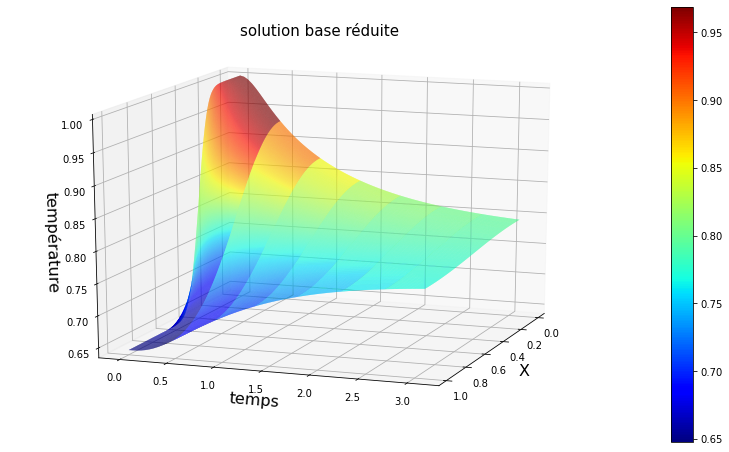

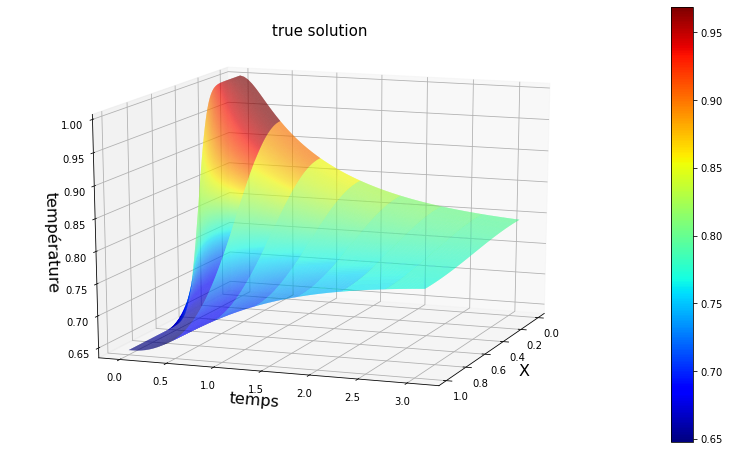

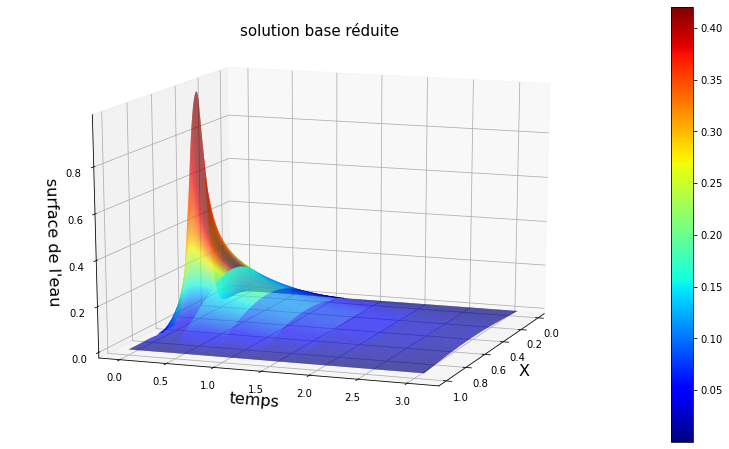

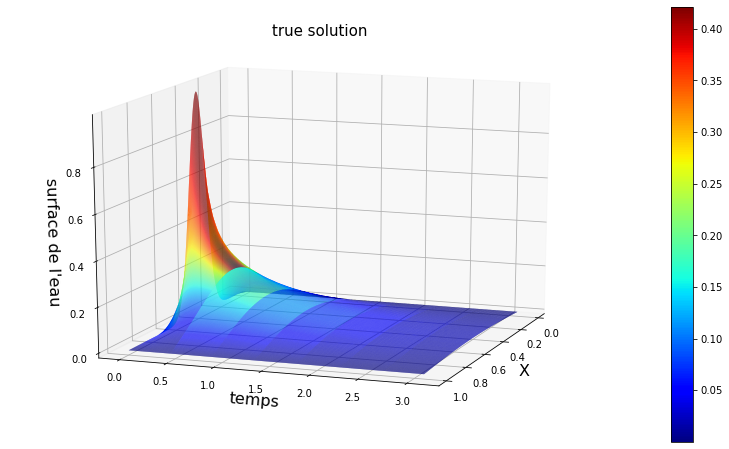

In [24]:
plot3D(x,t,U_found,"température","solution base réduite")
plot3D(x,t,U_true,"température","true solution")
Burger_found = sol_Burger_from_Heat(x[1]-x[0],U_found,param[0])
Burger_true = sol_Burger_from_Heat(x[1]-x[0],U_true,param[0])
plot3D(x_burger,t,Burger_found,"surface de l'eau","solution base réduite")
plot3D(x_burger,t,Burger_true,"surface de l'eau","true solution")

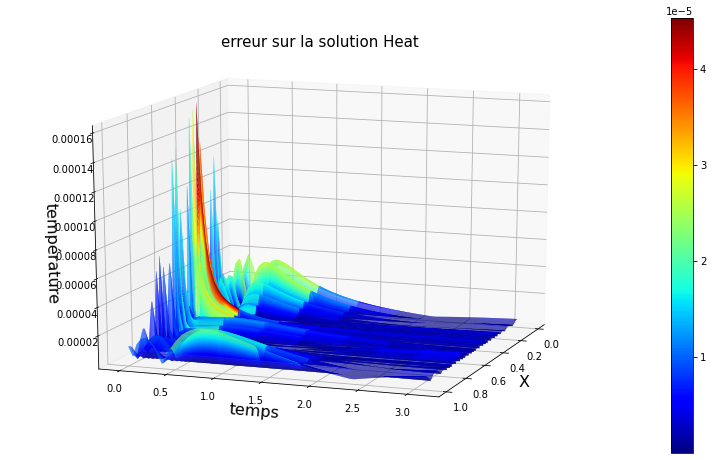

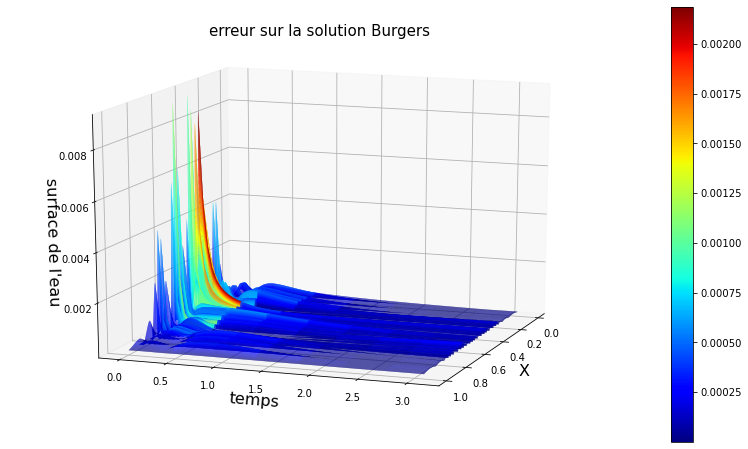

In [21]:
plot3D(x, t, abs(U_found - U_true), "température", "erreur sur la solution Heat")
plot3D(x_burger, t, abs(Burger_found - Burger_true), "surface de l'eau", "erreur sur la solution Burgers")

In [25]:
%%timeit
U_rb = reduced_solver_Heat(n,T_diff,Pre_computed_A,Base,param)
U_found = Base.dot(U_rb)
#Burger_found = sol_Burger_from_Heat(x[1]-x[0],U_found,param[0])

4.2 ms ± 93.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%%timeit
U_true = solver_diff_Heat(n,T_diff,param)
#Burger_true = sol_Burger_from_Heat(x[1]-x[0],U_true,param[0])

8.88 ms ± 63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
